Download books of two authors from the Gutenberg Project
Use HC scores to attribute each book to the corpus of its author.

Require packages 'gutenberg' and 'plotnine'

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

#import auxiliary functions for python
import sys

import sys
sys.path.append('../')
from AuthAttLib import *
from visualize_HC_scores import *

%matplotlib inline

## Dicknes vs Austin 

Run `Download_Dicknes_Austin.py' to create 'Dickens.csv' and 'Ausin.csv'

### Prepare data, remove header, clean symbols and digits

In [3]:
from text_processing import *

def clean_text(data) :
    HEADER = 1000 # remove first 1000 words, usually contains header information
    data.text = data.text.apply(lambda x : " ".join(x.split()[HEADER:])) #trim header
    data.text = data.text.apply(remove_hexa_symbols)
    data.text = data.text.apply(remove_digits)
    data = data.filter(['author', 'title', 'text']).rename(columns = {'title' : 'doc_id'})
    return data

Dickens_corpus = pd.read_csv('../Data/Dickens.csv')
Austin_corpus = pd.read_csv('../Data/Austin.csv')

data = pd.concat([clean_text(Dickens_corpus),
                  clean_text(Austin_corpus)])


### Remove proper nouns or other parts of speech, (optional)
(may take several minutes)

In [4]:
def remove_POS(text) :
    try :
        tx = remove_parts_of_speach(text,
                        to_remove = ('NNP','NNPS','CD'),
                        lemmatize = False)
    # 'NNP'-- proper noun, singluar
    # 'NNPS' -- proper noun, plural 
    # 'CD' -- cardinal digit
    # 'PRP' -- personal pronoun
    # 'PRP$' -- posessive pronoun
    except :
        tx = []
    return tx

data.loc[:,'text'] = data.text.apply(remove_POS)

<H3>Train Model</H3>
- To do: Understand why counts of some word differ after cleaning the dataset. 
- Perhaps try to use a single doc per class



In [5]:
model = AuthorshipAttributionMulti(data,
                        vocab_size = 3000, # number of features
                        words_to_ignore = ['?','.',',',':',';','!','-','"','(',')','``','```','`'],
                        ngram_range = (1,1), # how many ngram to use
                        )

	 Creating author-model for Charles Dickens using 3000 features...
		found 23 documents and 3579711 relevant tokens.
	 Creating author-model for Jane Austin using 3000 features...
		found 7 documents and 556529 relevant tokens.


## Compute and illustrate HC scores of each title with respect to the corpus of each author
(each work is removed from the corpus of its author when testing against this corpus. This is a leave-one-out performance evaluation procedure.)

/usr/local/lib/python3.7/site-packages/plotnine/utils.py:288: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  np.hstack([1, np.cumprod(ndistinct[:-1])]))
/usr/local/lib/python3.7/site-packages/plotnine/utils.py:289: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  mat = np.matrix(ids)
/usr/local/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.


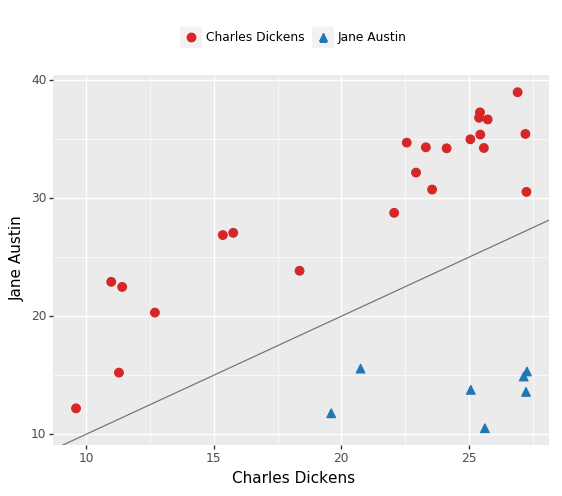

<ggplot: (305437813)>


/usr/local/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.7/site-packages/plotnine/utils.py:288: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  np.hstack([1, np.cumprod(ndistinct[:-1])]))
/usr/local/lib/python3.7/site-packages/plotnine/utils.py:289: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  mat = np.matrix(ids)
/usr/local/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not 

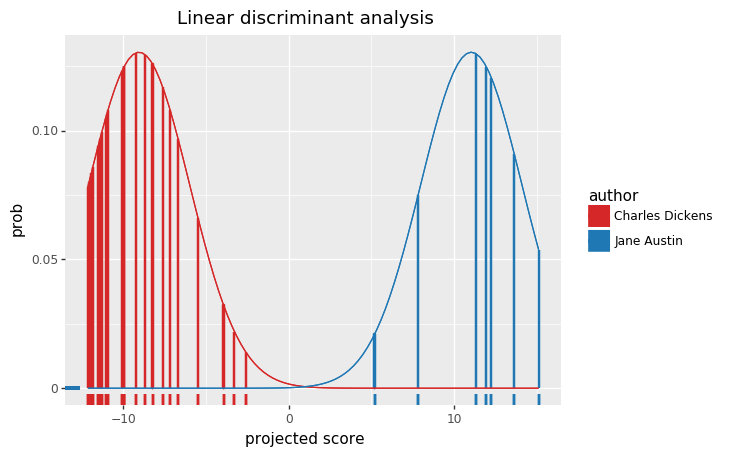

<ggplot: (305581885)>


In [6]:
#compute HC scores of document against each corpus 
df = model.internal_stats()
p = plot_author_pair(df, value = 'HC', wrt_authors=('Charles Dickens', 'Jane Austin'))
print(p)
p = plot_LDA(df, value = 'HC', wrt_authors=('Charles Dickens', 'Jane Austin'), sym = True)\
        + ggtitle('Linear discriminant analysis')
print(p)

<H2>Find distinguishing words or ngrams (features)</H2>

/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/site-packages/plotnine/utils.py:288: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  np.hstack([1, np.cumprod(ndistinct[:-1])]))
/usr/local/lib/python3.7/site-packages/plotnine/utils.py:289: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  mat = np.matrix(ids)
/usr/local/lib/python3.7/site-packages/numpy/

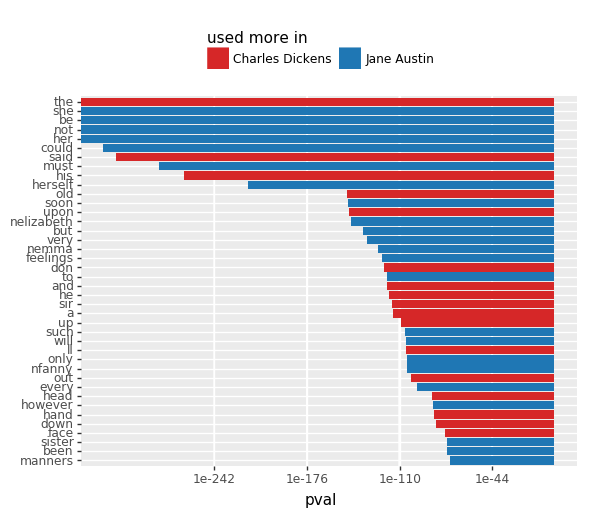

<ggplot: (305361329)>


In [7]:
df_pv = model.two_author_test('Charles Dickens','Jane Austin', )

df_desc = df_pv[df_pv.thresh].rename(columns = {'feat':'term'}).sort_values('pval')
p = plot_col(df_desc.head(40), value = 'pval', sign='sign', wrt_authors=('Charles Dickens','Jane Austin'))
print(p)

<H2>Reduce model to the set of discriminating features</H2>

In [22]:
disc_feat = df_desc.term.tolist()

	 Creating author-model for Charles Dickens using 599 features...
		found 23 documents and 2312011 relevant tokens.
	 Creating author-model for Jane Austin using 599 features...
		found 7 documents and 371443 relevant tokens.


/usr/local/lib/python3.7/site-packages/plotnine/utils.py:288: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  np.hstack([1, np.cumprod(ndistinct[:-1])]))
/usr/local/lib/python3.7/site-packages/plotnine/utils.py:289: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  mat = np.matrix(ids)
/usr/local/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.


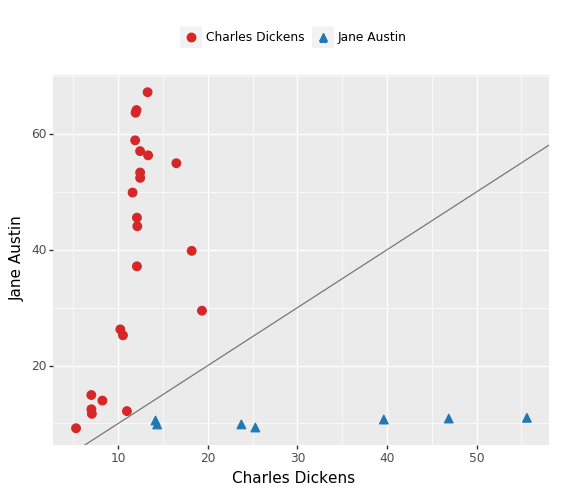

<ggplot: (306003793)>


In [23]:
#compute HC scores of document against each corpus 
model_red = AuthorshipAttributionMulti(data=data, vocab = disc_feat)
df = model_red.internal_stats()
p = plot_author_pair(df, value = 'HC', wrt_authors=('Charles Dickens', 'Jane Austin'))
print(p)